In [1]:
import eli5
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Ignore warnings
import warnings

warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams['figure.facecolor'] = 'white'
pd.set_option('display.float_format', '{:.3f}'.format)

# Load data

In [39]:
df = pd.read_csv("Healthcare-Diabetes.csv")

In [40]:
df.shape

(2768, 10)

# EDA

In [41]:
df.describe()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2768.000,2768.000,2768.000,2768.000,2768.000,2768.000,2768.000,2768.000,2768.000,2768.000
mean,1384.500,3.743,121.103,69.134,20.824,80.128,32.137,0.471,33.132,0.344
std,799.197,3.324,32.037,19.231,16.060,112.302,8.076,0.326,11.777,0.475
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,692.750,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,1384.500,3.000,117.000,72.000,23.000,37.000,32.200,0.375,29.000,0.000
75%,2076.250,6.000,141.000,80.000,32.000,130.000,36.625,0.624,40.000,1.000
max,2768.000,17.000,199.000,122.000,110.000,846.000,80.600,2.420,81.000,1.000


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        2768 non-null   int64  
 1   Pregnancies               2768 non-null   int64  
 2   Glucose                   2768 non-null   int64  
 3   BloodPressure             2768 non-null   int64  
 4   SkinThickness             2768 non-null   int64  
 5   Insulin                   2768 non-null   int64  
 6   BMI                       2768 non-null   float64
 7   DiabetesPedigreeFunction  2768 non-null   float64
 8   Age                       2768 non-null   int64  
 9   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 216.4 KB


In [43]:
# df.select_dtypes('object').head()

In [44]:
# df.isna().sum()

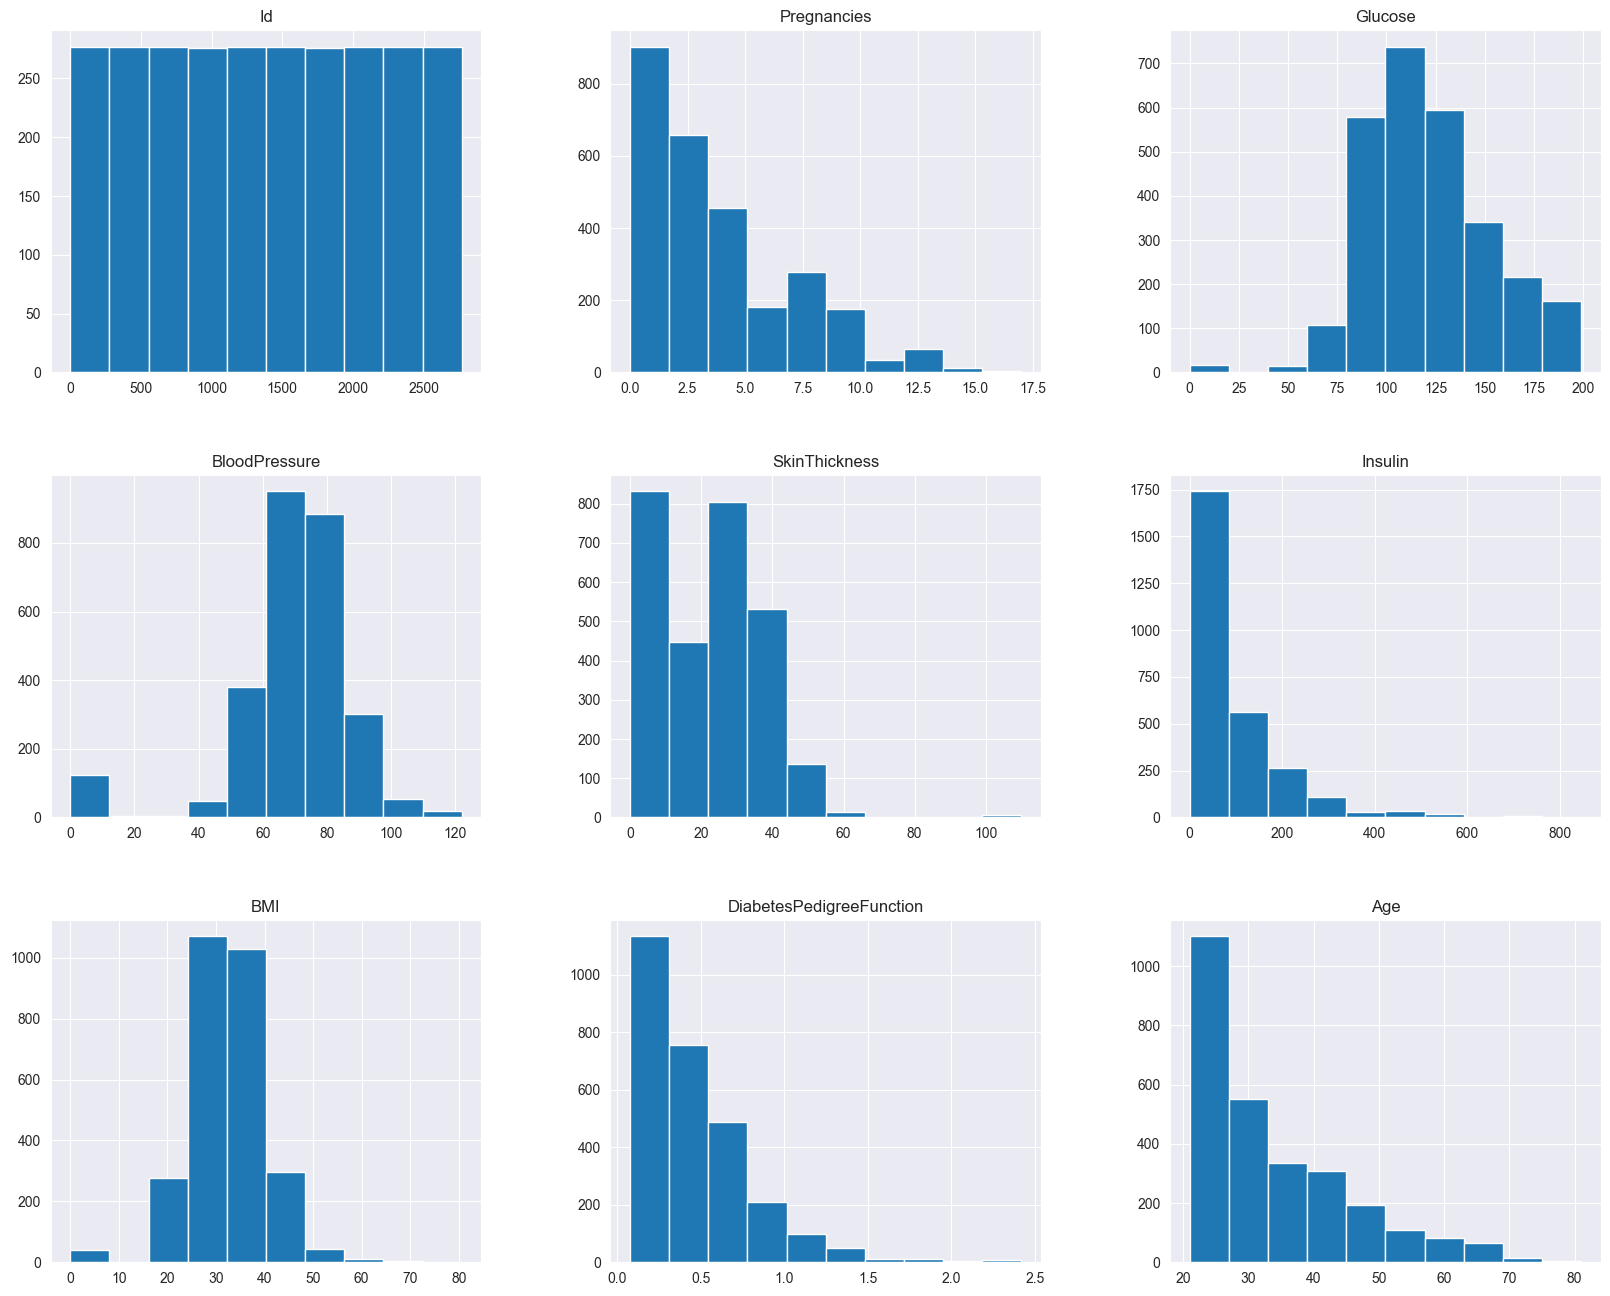

In [45]:
df[[f for f in df if f != 'Outcome']].hist(figsize=[20, 16])

plt.savefig('health_feats_histograms.png')

In [46]:
# Target

In [47]:
target_name = 'Outcome'

<Axes: title={'center': 'Distribution of Target Feature (Outcome)\n0 - no diabetes\n1 - diabetes'}>

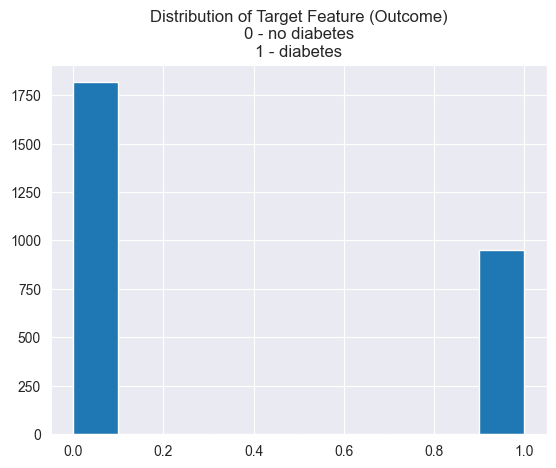

In [48]:
plt.title('Distribution of Target Feature (Outcome)\n0 - no diabetes\n1 - diabetes')

df[target_name].hist()

# Feature selection

In [49]:
removed_cols = [
    target_name,
    'Id',  # useless
]

# cols_to_normalize = [
#     'Insulin',
# ]

categorical = []

numerical = [f for f in df if f not in removed_cols]

In [50]:
all_columns = numerical

# Train, test, validation splits

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    df[all_columns],
    df[target_name],
    test_size=0.3,
    random_state=42,
    stratify=df[target_name],
)

In [53]:
y_train.value_counts()

Outcome
0    1271
1     666
Name: count, dtype: int64

In [54]:
y_test.value_counts()

Outcome
0    545
1    286
Name: count, dtype: int64

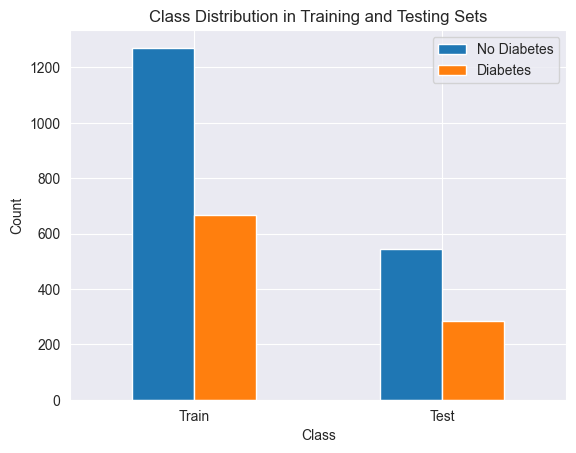

In [56]:
# Count the occurrences of each class in y_train and y_test
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

# Create a DataFrame for easy plotting
pd.DataFrame({'Train': train_counts, 'Test': test_counts}).T.plot(kind='bar')
plt.title('Class Distribution in Training and Testing Sets')
plt.xlabel('Class')
plt.ylabel('Count')

plt.xticks(rotation=0)

plt.legend(['No Diabetes', 'Diabetes'])
plt.show()

# processing pipeline

In [26]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Numeric Transformer: Imputation + Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # strategy='median'
    ('scaler', StandardScaler()),
])

# Numeric Transformer: Imputation + Scaling
normalize_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # strategy='median'
    ('log', FunctionTransformer(np.log1p)),
    ('imputer_default', SimpleImputer(fill_value=0)),
    ('scaler', StandardScaler()),
])

# Categorical Transformer: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    # ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ('enc', TargetEncoder(target_type='continuous')),
])

# Combine both Numeric and Categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        # ('norm', normalize_transformer, cols_to_normalize),
        # ('cat', categorical_transformer, categorical),
    ],
    remainder='drop'  # Columns not specified will be passed through
)

# Final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)]).set_output(transform='pandas')


In [27]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age'])]))])

In [28]:
X_train_transformed = pipeline.fit_transform(X_train, y_train)

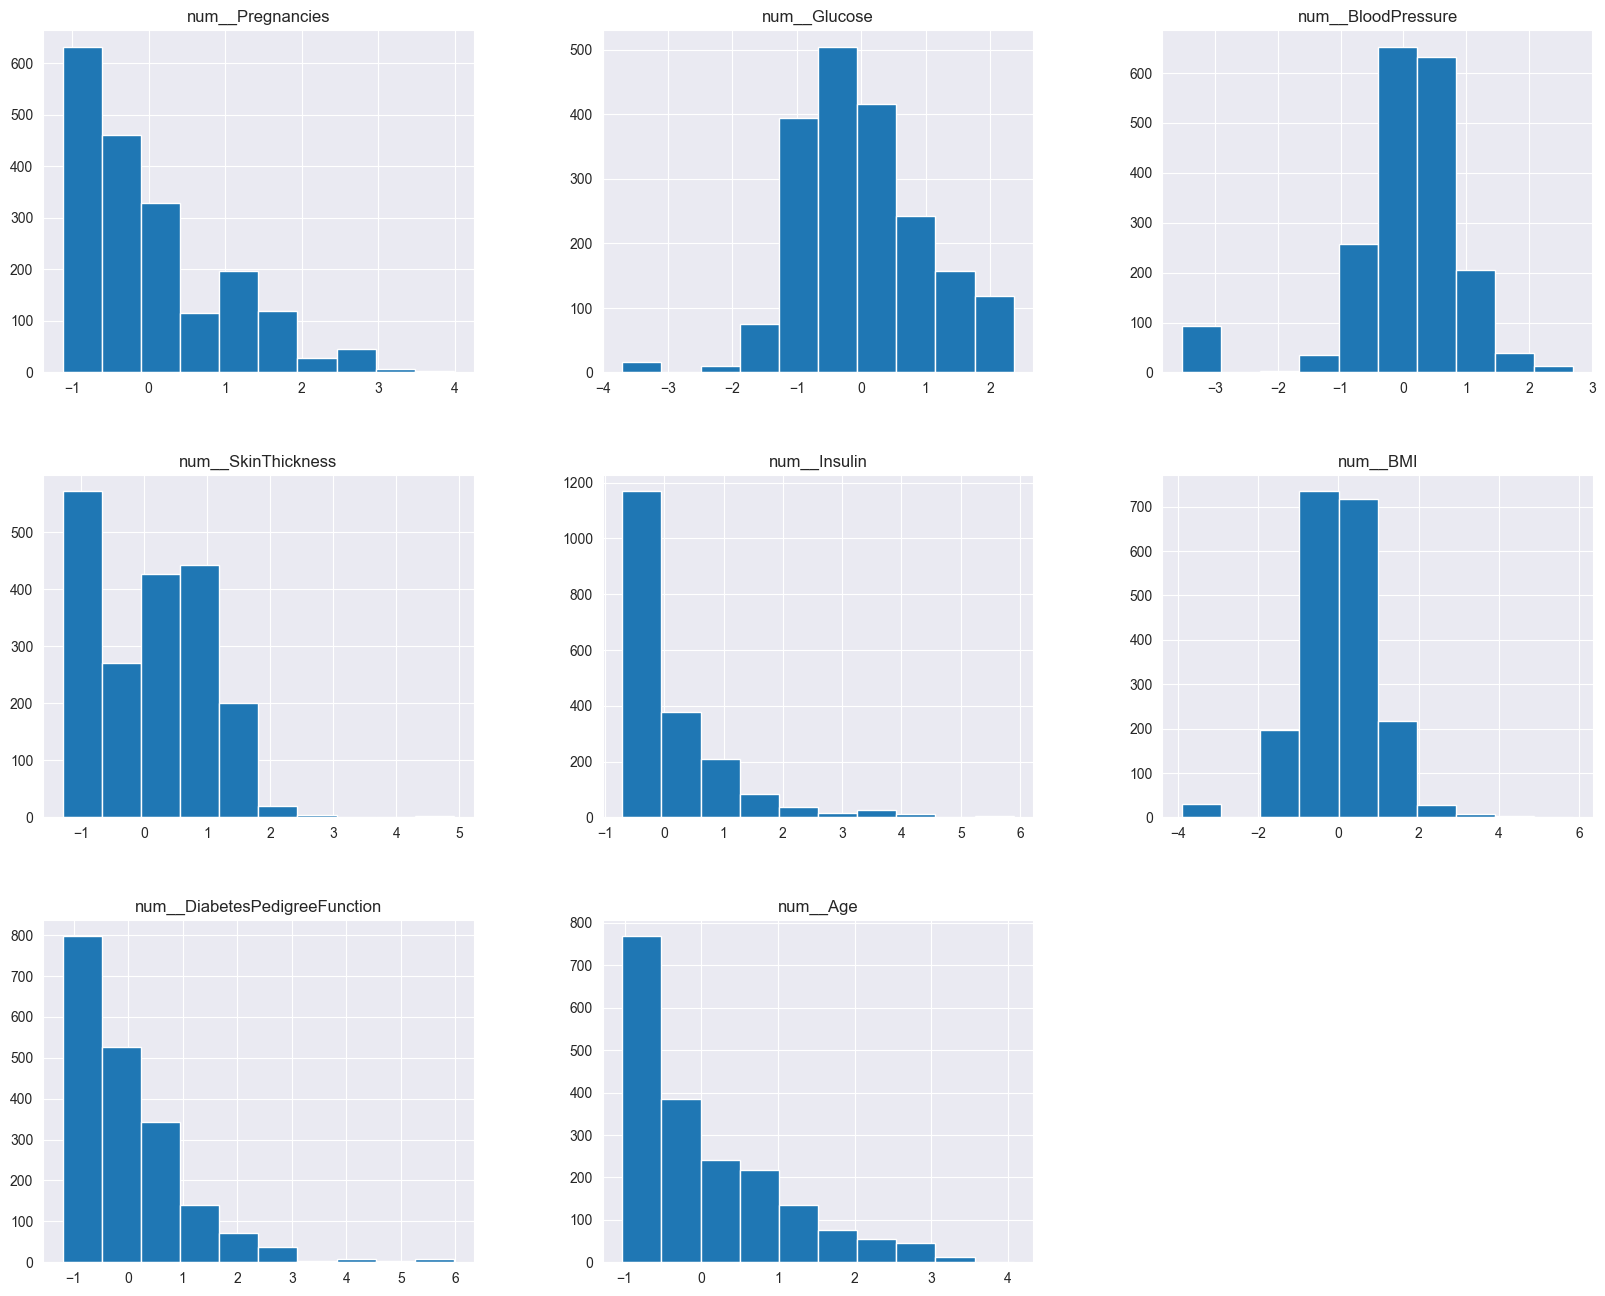

In [32]:
X_train_transformed.hist(figsize=[20, 16])

plt.savefig('health_feats_histograms_scaled.png')

In [31]:
X_test_transformed = pipeline.transform(X_test)

# Fit

In [58]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, cohen_kappa_score, \
    classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import confusion_matrix




# Initialize models list
models = [
    ('Dummy', DummyClassifier(strategy="stratified", random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('LogisticRegression', LogisticRegression(random_state=42)),
    ('Ridge', RidgeClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('NN', MLPClassifier(random_state=42))
]

# Initialize an empty list to store metrics
metrics_list = []

# Loop through models
for name, model in models:
    # Fit the model
    model.fit(X_train_transformed, y_train)

    # Initialize dict for this model's metrics
    model_metrics = {'Model': name}

    print('#' * 64)
    print(name)
    for dataset, X, y in [
        ('Train', X_train_transformed, y_train),
        ('Test', X_test_transformed, y_test),
    ]:
        # Make predictions
        y_pred = model.predict(X)
        try:
            y_prob = model.predict_proba(X)[:, 1]
        except AttributeError:
            print(f'Model {name} has no predict_proba. Hard prediction used')
            y_prob = y_pred

        # Compute metrics
        f1 = f1_score(y, y_pred,)
        precision = precision_score(y, y_pred,)
        recall = recall_score(y, y_pred,)
        auc = roc_auc_score(y, y_prob)
        kappa = cohen_kappa_score(y, y_pred)

        print(dataset)
        print(classification_report(y, y_pred))
        print(confusion_matrix(y, y_pred))

        # Append metrics to dict
        model_metrics.update({
            f'{dataset}_F1_Score': f1,
            f'{dataset}_Precision': precision,
            f'{dataset}_Recall': recall,
            # f'{dataset}_AUC': auc,
            f'{dataset}_Kappa': kappa
        })

    # Append model metrics to list
    metrics_list.append(model_metrics)

# Convert list of metrics to DataFrame
metrics_df = pd.DataFrame(metrics_list, index=[i[0] for i in models])

################################################################
Dummy
Train
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1271
           1       0.35      0.35      0.35       666

    accuracy                           0.55      1937
   macro avg       0.51      0.51      0.51      1937
weighted avg       0.56      0.55      0.56      1937

[[839 432]
 [430 236]]
Test
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       545
           1       0.35      0.35      0.35       286

    accuracy                           0.56       831
   macro avg       0.51      0.51      0.51       831
weighted avg       0.55      0.56      0.56       831

[[364 181]
 [187  99]]
################################################################
RandomForest
Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00  

In [59]:
metrics_df[[f for f in metrics_df if 'Test' in f]]

,Test_F1_Score,Test_Precision,Test_Recall,Test_Kappa
Dummy,0.350,0.354,0.346,0.014
RandomForest,0.974,0.982,0.965,0.960
LightGBM,0.972,0.972,0.972,0.957
XGBoost,0.977,0.982,0.972,0.965
LogisticRegression,0.580,0.726,0.483,0.421
Ridge,0.567,0.727,0.465,0.408
KNN,0.731,0.773,0.692,0.601
NN,0.713,0.764,0.668,0.577


In [60]:
metrics_df[[f for f in metrics_df if 'Train' in f]]

,Train_F1_Score,Train_Precision,Train_Recall,Train_Kappa
Dummy,0.354,0.353,0.354,0.014
RandomForest,1.000,1.000,1.000,1.000
LightGBM,1.000,1.000,1.000,1.000
XGBoost,1.000,1.000,1.000,1.000
LogisticRegression,0.650,0.739,0.581,0.499
Ridge,0.644,0.738,0.571,0.491
KNN,0.891,0.898,0.884,0.835
NN,0.817,0.853,0.784,0.727


# Explain

## Eli5

In [61]:
import eli5
eli5.explain_weights_df(models[3][1], feature_names=list(X_train_transformed.columns))

,feature,weight
0,num__Glucose,0.258
1,num__BMI,0.149
2,num__Age,0.136
3,num__BloodPressure,0.095
4,num__Pregnancies,0.093
5,num__SkinThickness,0.091
6,num__DiabetesPedigreeFunction,0.090
7,num__Insulin,0.087


In [62]:
eli5.explain_prediction_df(models[4][1], X_test_transformed.iloc[0], feature_names=list(X_train_transformed.columns))

,target,feature,weight,value
0,0,<BIAS>,0.897,1.000
1,0,num__Glucose,0.567,-0.503
2,0,num__Pregnancies,0.222,-0.522
3,0,num__DiabetesPedigreeFunction,0.203,-0.754
4,0,num__Age,0.096,-0.690
5,0,num__Insulin,0.016,0.124
6,0,num__SkinThickness,-0.087,1.212
7,0,num__BloodPressure,-0.124,-0.564
8,0,num__BMI,-0.213,0.328


## LIME

In [63]:
from lime.lime_tabular import LimeTabularExplainer

In [103]:
explainer = LimeTabularExplainer(
    X_train_transformed.values,
    feature_names=list(X_train_transformed.columns),
    class_names=['normal', 'diabetes'],
    discretize_continuous=True,
)

In [105]:
exp = explainer.explain_instance(X_test_transformed.iloc[7], models[3][1].predict_proba)

In [106]:
n = 7
models[3][1].predict_proba(X_test_transformed.iloc[n:n + 1])

array([[0.04692084, 0.95307916]], dtype=float32)

In [107]:
y_test

2394    0
1876    0
1551    0
2498    1
1073    0
       ..
2532    1
2621    0
1675    0
2313    0
1053    0
Name: Outcome, Length: 831, dtype: int64

Figure(640x480)


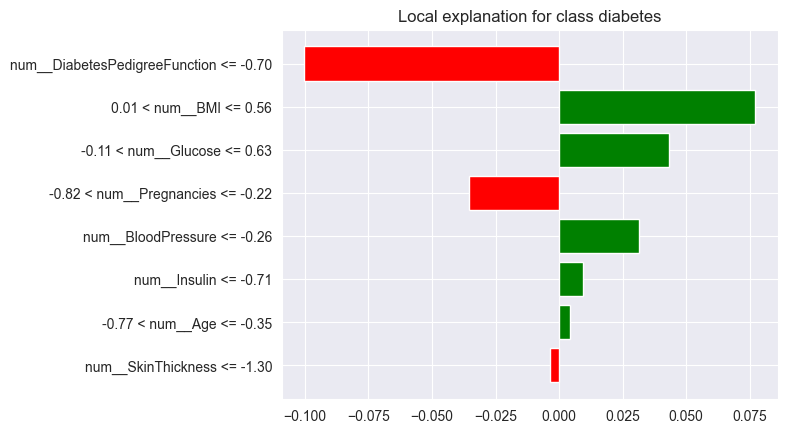

In [108]:
print(exp.as_pyplot_figure())

In [82]:
exp.as_list()

[('-0.69 < num__Glucose <= -0.11', -0.18584883155050436),
 ('num__DiabetesPedigreeFunction <= -0.70', -0.09885743801640719),
 ('0.01 < num__BMI <= 0.56', 0.09819131847133915),
 ('-0.82 < num__Pregnancies <= -0.22', -0.05118366428352578),
 ('num__SkinThickness > 0.71', 0.04277638358801049),
 ('-0.77 < num__Age <= -0.35', -0.026981912076201178),
 ('num__BloodPressure <= -0.26', 0.015574857250370807),
 ('-0.39 < num__Insulin <= 0.44', -0.00424263820576014)]

In [83]:
explainer_unscaled = LimeTabularExplainer(
    X_train.values,
    feature_names=list(X_train_transformed.columns),
    class_names=['normal', 'diabetes'],
    discretize_continuous=True,
)

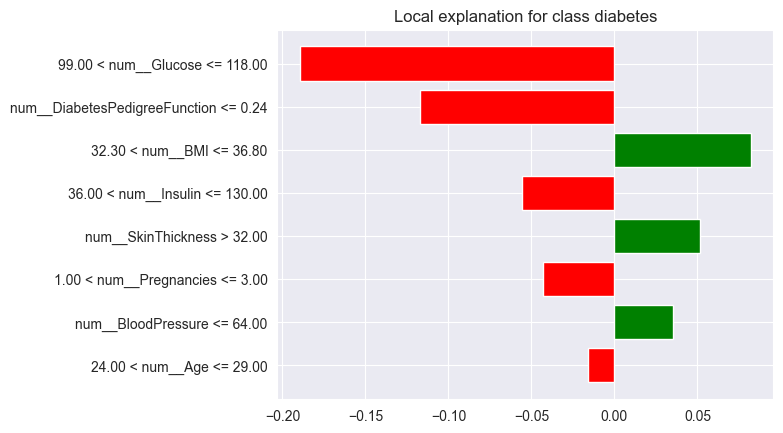

In [84]:
explainer_unscaled.explain_instance(X_test.iloc[0], lambda x: models[3][1].predict_proba(
    pipeline.transform(pd.DataFrame(x, columns=X_train.columns))
)).as_pyplot_figure()

plt.show()

## SHAP

In [85]:
import shap


mlp = models[4][1]
# Initialize the SHAP Explainer
explainer = shap.KernelExplainer(lambda x: mlp.predict_proba(
    pipeline.transform(pd.DataFrame(x, columns=X_train.columns))
), X_train.head(100))

In [86]:
shap_values = explainer.shap_values(X_test)

  0%|          | 0/831 [00:00<?, ?it/s]

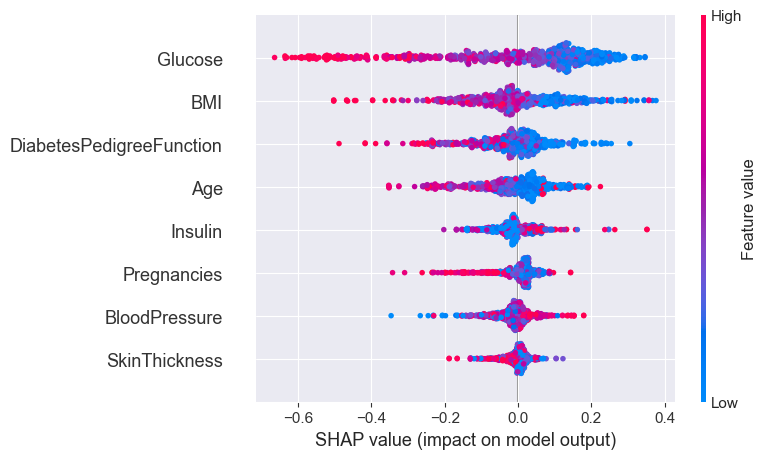

In [87]:
shap.summary_plot(shap_values[0], X_test)

# T-SNE

In [89]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(X_train_transformed)

In [90]:
# Create a DataFrame to hold the t-SNE results
df_tsne = pd.DataFrame(data=tsne_results, columns=['Dimension 1', 'Dimension 2'])
df_tsne['target'] = y_train

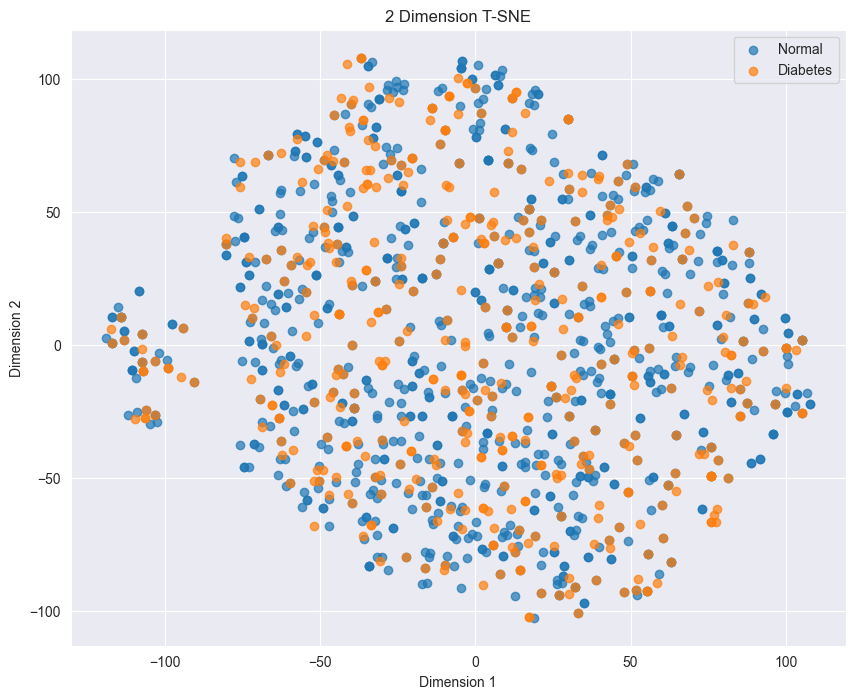

In [91]:
import numpy as np

plt.figure(figsize=(10, 8))

# Plot each category
for label in np.unique(df_tsne['target']):

    plt.scatter(
        df_tsne.loc[df_tsne.target == label]['Dimension 1'],
        df_tsne.loc[df_tsne.target == label]['Dimension 2'],
        label=label,
        alpha=0.7
    )

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2 Dimension T-SNE')
plt.legend(['Normal', 'Diabetes'])
plt.show()